# Mode Selection

The mode selection module is paramount to the computational efficiency of this model. Below we show how we perform this selection operation by moving from a set of amplitudes to only those that contribute. 

### Mode selection by power contribution

Modes can also be weighted by a Power Spectral Density (PSD) function from your favorite sensitivity curve. 

In [29]:
# first, lets get amplitudes for a trajectory
traj = EMRIInspiral(func=SchwarzEccFlux)

# parameters
M = 1e5
mu = 1e1
p0 = 10.0
e0 = 0.7
theta = np.pi/3.
phi = np.pi/2.

t, p, e, x, Phi_phi, Phi_theta, Phi_r = traj(M, mu, 0.0, p0, e0, 1.0)

# get amplitudes along trajectory
amp = RomanAmplitude()

# Schwarzschild
a = 0.0

teuk_modes = amp(a, p, e, x)

# get ylms
ylms = ylm_gen(amp.unique_l, amp.unique_m, theta, phi).copy()[amp.inverse_lm]

# select modes

mode_selector = ModeSelector(amp.l_arr_no_mask, amp.m_arr_no_mask, amp.n_arr_no_mask, use_gpu=False)

eps = 1e-5  # tolerance on mode contribution to total power

modeinds = [amp.l_arr, amp.m_arr, amp.n_arr]
(teuk_modes_in, ylms_in, ls, ms, ns) = mode_selector(teuk_modes, ylms, modeinds, eps=eps)

print("We reduced the mode content from {} modes to {} modes.".format(teuk_modes.shape[1], teuk_modes_in.shape[1]))

We reduced the mode content from 3843 modes to 874 modes.


### Mode selection by noise-weighted power contribution

In [30]:
# produce sensitivity function

noise = np.genfromtxt("files/LPA.txt", names=True)
f, PSD = (
    np.asarray(noise["f"], dtype=np.float64),
    np.asarray(noise["ASD"], dtype=np.float64) ** 2,
)

sens_fn = CubicSplineInterpolant(f, PSD, use_gpu=False)

# select modes with noise weighting

# provide sensitivity function kwarg
mode_selector_noise_weighted = ModeSelector(amp.l_arr_no_mask, amp.m_arr_no_mask, amp.n_arr_no_mask, sensitivity_fn=sens_fn, use_gpu=False)

eps = 1e-5  # tolerance on mode contribution to total power

fund_freq_args = (M, a, p , e, x, t)

modeinds = [amp.l_arr, amp.m_arr, amp.n_arr]
(teuk_modes_in, ylms_in, ls, ms, ns) = mode_selector_noise_weighted(teuk_modes, ylms, modeinds,
                                                                    fund_freq_args=fund_freq_args, eps=eps)

print("We reduced the mode content from {} modes to {} modes when using noise-weighting.".format(teuk_modes.shape[1], teuk_modes_in.shape[1]))

We reduced the mode content from 3843 modes to 781 modes when using noise-weighting.


/Users/c.chapman-bird@bham.ac.uk/work/few/kerreqecc/FastEMRIWaveforms/few/summation/interpolatedmodesum.py:216: UserWarning: New t array outside bounds of input t array. These points are filled with edge values.
  warnings.warn(


### Compare the two waves with and without noise-weighting

mismatch: 7.537825494230432e-06
base modes: 249
noise-weighted modes: 447


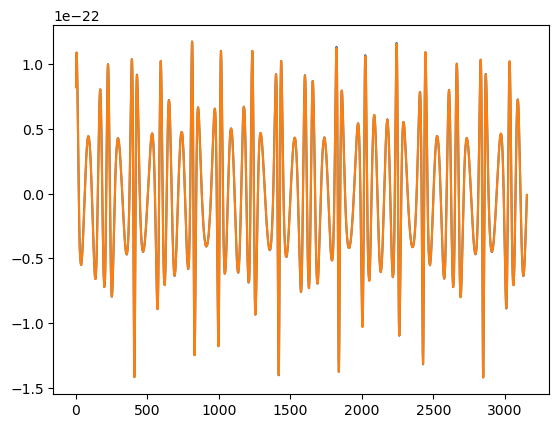

In [31]:
noise_weighted_mode_selector_kwargs = dict(sensitivity_fn=sens_fn)

few_base = FastSchwarzschildEccentricFlux(
    inspiral_kwargs=inspiral_kwargs,
    amplitude_kwargs=amplitude_kwargs,
    Ylm_kwargs=Ylm_kwargs,
    sum_kwargs=sum_kwargs,
    use_gpu=use_gpu,
)

few_noise_weighted = FastSchwarzschildEccentricFlux(
    inspiral_kwargs=inspiral_kwargs,
    amplitude_kwargs=amplitude_kwargs,
    Ylm_kwargs=Ylm_kwargs,
    sum_kwargs=sum_kwargs,
    mode_selector_kwargs=noise_weighted_mode_selector_kwargs,
    use_gpu=use_gpu,
)

M = 1e6
mu = 1e1
p0 = 12.0
e0 = 0.3
theta = np.pi/3.
phi = np.pi/4.
dist = 1.0
dt = 10.0
T = 0.001

wave_base = few_base(M, mu, p0, e0, theta, phi, dist=dist, dt=dt, T=T)
wave_weighted = few_noise_weighted(M, mu, p0, e0, theta, phi, dist=dist, dt=dt, T=T)

plt.plot(wave_base.real)
plt.plot(wave_weighted.real)

print('mismatch:', get_mismatch(wave_base, wave_weighted))
print('base modes:', few_base.num_modes_kept)
print('noise-weighted modes:', few_noise_weighted.num_modes_kept)

### Specific mode selection

The user can also select a specific set of modes to use in the waveform.

mismatch with full wave: 0.0489371197994426


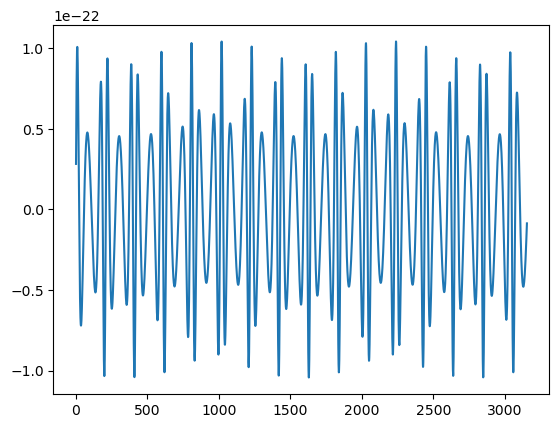

In [32]:
# l = 2, m = 2 wave
specific_modes = [(2, 2, n) for n in range(-30, 31)]

wave_22 = few_base(M, mu, p0, e0, theta, phi, dist=dist, dt=dt, T=T, mode_selection=specific_modes)

plt.plot(wave_22.real)

print('mismatch with full wave:', get_mismatch(wave_22, wave_base))

### Turn off ($-m$)

By default, symmetry is used to generate $-m$ modes. To turn this off and only use modes with ($m$), provide `False` to the `include_minus_m` kwarg. This only affects the waveform when `mode_selection` is a list of specific modes. 

mismatch with 22 wave with + and - m: 1.0013502949095578
mismatch with 22 original wave with adding + and - m 0.0


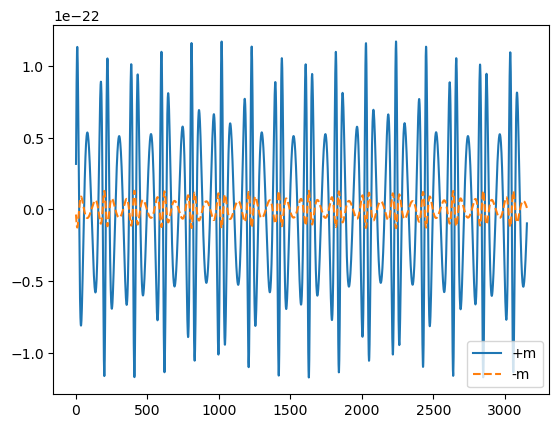

In [33]:
%matplotlib inline
# l = 2, m = 2 wave without m = -2
specific_modes = [(2, 2, n) for n in range(-30, 31)]

specific_modes_minus_m = [(2, -2, n) for n in range(-30, 31)]

wave_22_pos_m = few_base(M, mu, p0, e0, theta, phi, 
                   dist=dist, dt=dt, T=0.001, 
                   mode_selection=specific_modes, include_minus_m=False)

wave_22_minus_m = few_base(M, mu, p0, e0, theta, phi, 
                   dist=dist, dt=dt, T=0.001, 
                   mode_selection=specific_modes_minus_m, include_minus_m=False)

plt.plot(wave_22_pos_m.real, label='+m')
plt.plot(wave_22_minus_m.real, label='-m', ls='--')
plt.legend()
print('mismatch with 22 wave with + and - m:', get_mismatch(wave_22_minus_m, wave_22_pos_m))

print('mismatch with 22 original wave with adding + and - m', get_mismatch(wave_22, wave_22_pos_m + wave_22_minus_m))
